## Dirichlet Process Mixture Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

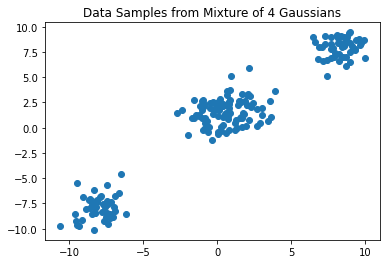

In [2]:
#create data

data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In [3]:
# stick-breaking function that generates our weights 
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [5]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha)) # beta_i samples are conditionally independent

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) # Categorical distribution whose parameters are the mixture weights using our sampled beta values
        # Finally, we sample our observations from a multivariate Gaussian distribution 
        # whose mean is exactly the cluster parameter corresponding to the assignment z_n we drew for the point x_n 
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2))) # tau means of posterior multivariate distribution

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi)) # phi prob of choosing zi -> will be posterior weights for the multivariate means

In [8]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 1000.
    true_centers = centers[weights > threshold] # remove clusters which have a too small probability
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold]) # re-normalize weights so that they sum to one
    
    idx_kept = torch.topk(weights, true_centers.shape[0])[1]
    return true_centers, true_weights, idx_kept
    
alpha = 0.01
train(1000)

100%|██████████| 1000/1000 [00:18<00:00, 54.17it/s]


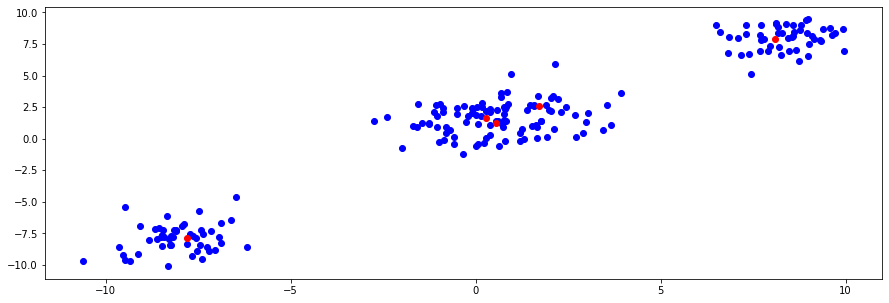

In [9]:
# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01, idx_kept = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.show()

In [11]:
# extract posterior for beta and z
posterior = Predictive(guide, num_samples=len(data), return_sites=["beta","z"])(data)
post_pred_weights = mix_weights(posterior["beta"])
post_pred_clusters = posterior["z"]

In [10]:
# reassign clusters from those kept by truncate function
assignment = [torch.argmax(i) for i in pyro.param("phi").detach()[:,[list(idx_kept)]]]

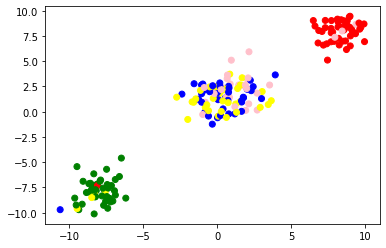

In [12]:
# visualize colored clusters
col = ["red","blue","green","yellow","pink","black"]
clusts = []
for idx,p in enumerate(data):
    clusts.append(col[assignment[idx]])

plt.scatter(data[:, 0], data[:, 1], color=clusts)

## Segmentation

Very simple starting example on how to use Gaussian mixture to do segmentation.

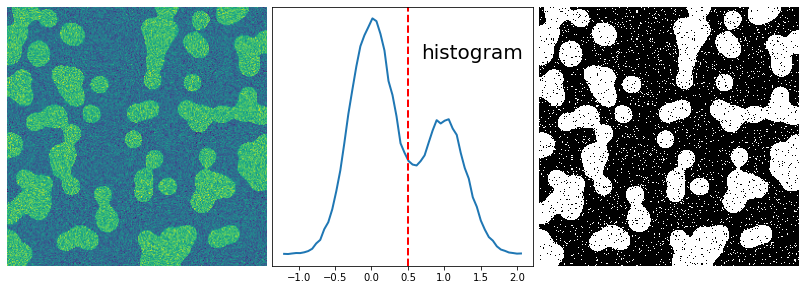

In [14]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import warnings 
warnings.filterwarnings('ignore')


np.random.seed(1)
n = 10
l = 256
im = np.zeros((l, l))  # im lxl
points = l*np.random.random((3, n**2))

im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1 # random noise

im = ndimage.gaussian_filter(im, sigma=l/(4.*n))

mask = (im > im.mean()).astype(np.float)

img = mask + 0.3*np.random.randn(*mask.shape)

hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

classif = GaussianMixture(n_components=2)
classif.fit(img.reshape((img.size, 1)))

threshold = np.mean(classif.means_)
binary_img = img > threshold


plt.figure(figsize=(11,4))

plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.subplot(132)
plt.plot(bin_centers, hist, lw=2)
plt.axvline(0.5, color='r', ls='--', lw=2)
plt.text(0.57, 0.8, 'histogram', fontsize=20, transform = plt.gca().transAxes)
plt.yticks([])
plt.subplot(133)
plt.imshow(binary_img, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()